In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import shap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import joblib

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Datasets/PHL_HWC.csv")
data.head()

,P_NAME,P_DETECTION,P_DISCOVERY_FACILITY,P_YEAR,P_UPDATE,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_MASS_LIMIT,P_MASS_ORIGIN,...,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG
0,OGLE-2016-BLG-1227L b,Microlensing,OGLE,2020,2020-04-02,250.00,-120.0,413.0,0,Mass,...,NaN,0.214133,0,0,NaN,0,NaN,Scorpius,Sco,Scorpion
1,Kepler-276 c,Transit,Kepler,2013,2018-09-25,16.60,-3.6,4.4,0,Mass,...,2.097783,0.316980,0,0,Hot,0,0.272032,Cygnus,Cyg,Swan
2,Kepler-829 b,Transit,Kepler,2016,2019-04-16,5.10,NaN,NaN,0,M-R relationship,...,1.756317,0.459559,0,0,Hot,0,0.254763,Lyra,Lyr,Lyre
3,K2-283 b,Transit,K2,2018,2019-09-05,12.20,NaN,NaN,0,M-R relationship,...,0.568374,0.443760,0,0,Hot,0,0.193906,Pisces,Psc,Fishes
4,Kepler-477 b,Transit,Kepler,2016,2019-04-16,4.94,NaN,NaN,0,M-R relationship,...,0.768502,0.386150,0,0,Hot,0,0.276721,Lyra,Lyr,Lyre


In [ ]:
numeric_data = data.select_dtypes(include=[np.number])
numeric_data = numeric_data.dropna(subset=['P_HABITABLE'])
X = numeric_data.drop(columns=['P_HABITABLE'])
y = numeric_data['P_HABITABLE']

In [ ]:
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

In [ ]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Train a Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
gb_accuracy = accuracy_score(y_test, gb_model.predict(X_test))

In [ ]:
rf_cv_scores = cross_val_score(rf_model, X_imputed, y, cv=5, scoring='accuracy')
gb_cv_scores = cross_val_score(gb_model, X_imputed, y, cv=5, scoring='accuracy')
rf_cv_mean = rf_cv_scores.mean()
gb_cv_mean = gb_cv_scores.mean()

In [ ]:
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
gb_importances = pd.Series(gb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

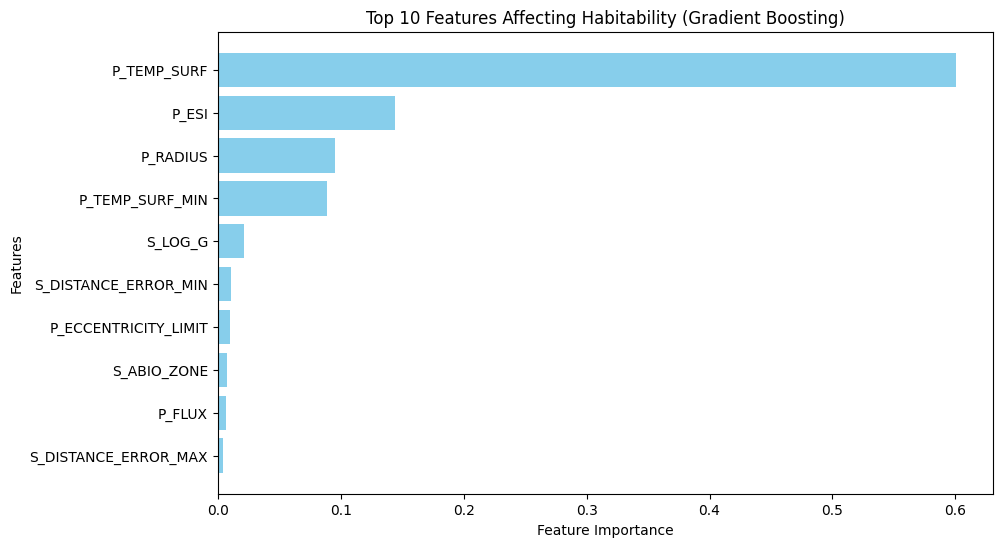

In [ ]:
# Plot feature importance from Gradient Boosting
plt.figure(figsize=(10, 6))
plt.barh(gb_importances.head(10).index[::-1], gb_importances.head(10)[::-1], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Features Affecting Habitability (Gradient Boosting)')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

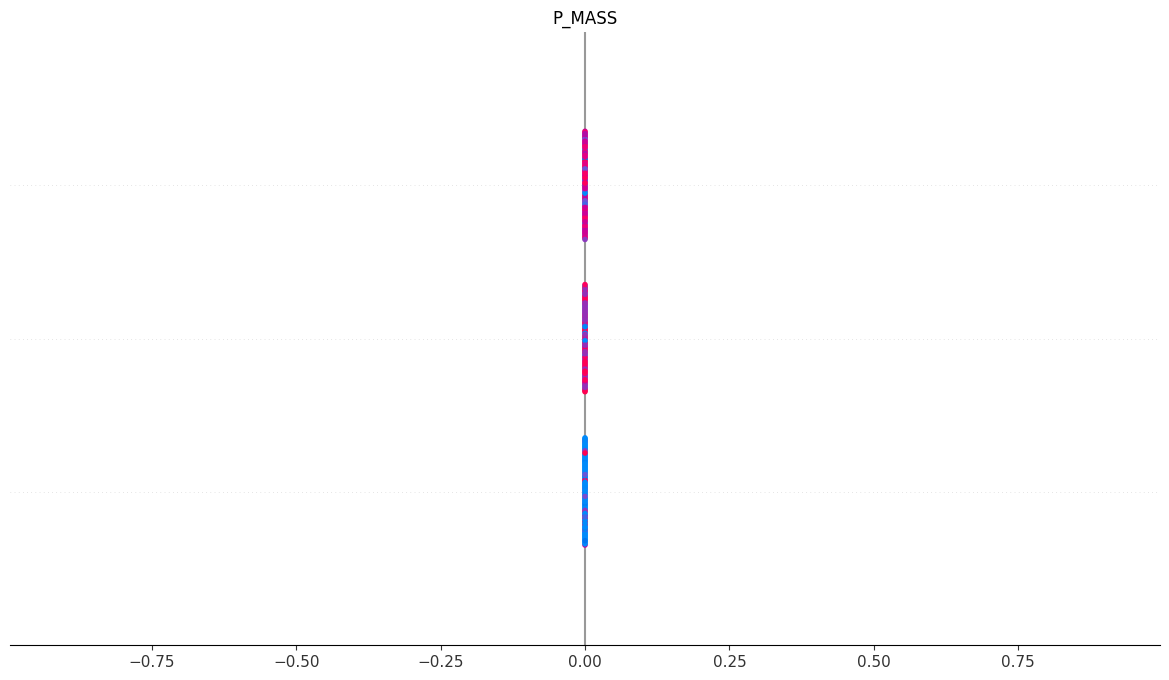

In [ ]:
sample_data = X_train.sample(100, random_state=42)  # Use a subset for efficiency

# Initialize KernelExplainer
explainer = shap.KernelExplainer(gb_model.predict_proba, sample_data)

# Compute SHAP values (for a subset of test data to save time)
shap_values = explainer.shap_values(X_test.sample(100, random_state=42))

# SHAP summary plot
shap.summary_plot(shap_values, X_test.sample(100, random_state=42))

In [ ]:
# Print final conclusion
print("Random Forest Accuracy (Test Set):", rf_accuracy)
print("Gradient Boosting Accuracy (Test Set):", gb_accuracy)
print("Random Forest Cross-Validation Accuracy:", rf_cv_mean)
print("Gradient Boosting Cross-Validation Accuracy:", gb_cv_mean)
print("Top 10 Features Affecting Habitability (Gradient Boosting):")
print(gb_importances.head(10))

Random Forest Accuracy (Test Set): 1.0
Gradient Boosting Accuracy (Test Set): 0.9982142857142857
Random Forest Cross-Validation Accuracy: 0.9982139665517682
Gradient Boosting Cross-Validation Accuracy: 0.9983928571428571
Top 10 Features Affecting Habitability (Gradient Boosting):
P_TEMP_SURF             0.600394
P_ESI                   0.144494
P_RADIUS                0.095145
P_TEMP_SURF_MIN         0.088490
S_LOG_G                 0.021136
S_DISTANCE_ERROR_MIN    0.010748
P_ECCENTRICITY_LIMIT    0.009585
S_ABIO_ZONE             0.007171
P_FLUX                  0.006558
S_DISTANCE_ERROR_MAX    0.004547
dtype: float64


In [ ]:
# Drop rows with missing target values
target_columns = ["P_HABZONE_OPT", "P_HABZONE_CON", "P_HABITABLE", "P_ESI"]
numeric_data = numeric_data.dropna(subset=target_columns)

In [ ]:
important_features = [
    "P_TEMP_SURF", "P_RADIUS", "P_TEMP_SURF_MIN",
    "S_LOG_G", "S_DISTANCE_ERROR_MIN", "P_ECCENTRICITY_LIMIT",
    "S_ABIO_ZONE", "P_FLUX", "S_DISTANCE_ERROR_MAX"
]

In [ ]:
X = numeric_data[important_features]
Y = numeric_data[target_columns]

In [ ]:
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [ ]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

In [ ]:
rf_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
rf_model.fit(X_train, Y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [ ]:
Y_pred = rf_model.predict(X_test)

In [ ]:
mae = mean_absolute_error(Y_test, Y_pred, multioutput='raw_values')
r2 = r2_score(Y_test, Y_pred, multioutput='variance_weighted')

In [ ]:

print("Mean Absolute Error for each target:", mae)
print("Overall R² Score:", r2)

Mean Absolute Error for each target: [0.00709888 0.0036847  0.00051306 0.00213617]
Overall R² Score: 0.9410389504859675


In [ ]:
random_planet = pd.DataFrame([{
    "P_TEMP_SURF": 288.0,               # Earth-like surface temp
    "P_RADIUS": 1.0,                    # Earth-sized
    "P_TEMP_SURF_MIN": 260.0,           # Coldest zone
    "S_LOG_G": 4.4,                     # Similar to Sun
    "S_DISTANCE_ERROR_MIN": 0.005,      # Low error
    "P_ECCENTRICITY_LIMIT": 0.02,       # Circular orbit
    "S_ABIO_ZONE": 0.8,                 # Supports abiogenesis
    "P_FLUX": 1.1,                      # Earth-like insolation
    "S_DISTANCE_ERROR_MAX": 0.01        # Low error
}])

# hostile_planet = pd.DataFrame([{
#     "P_TEMP_SURF": 1000.0,
#     "P_RADIUS": 10.0,
#     "P_TEMP_SURF_MIN": 800.0,
#     "S_LOG_G": 5.5,
#     "S_DISTANCE_ERROR_MIN": 1.0,
#     "P_ECCENTRICITY_LIMIT": 0.9,
#     "S_ABIO_ZONE": 0.0,
#     "P_FLUX": 10.0,
#     "S_DISTANCE_ERROR_MAX": 2.0
# }])

In [ ]:
# Impute any missing values (if needed)
hostile_planet_imputed = pd.DataFrame(imputer.transform(random_planet), columns=random_planet.columns)

# Scale using the same scaler as training
hostile_planet_scaled = pd.DataFrame(scaler.transform(hostile_planet_imputed), columns=random_planet.columns)

# Predict
prediction = rf_model.predict(hostile_planet_scaled)

In [ ]:
for name, value in zip(target_columns, prediction[0]):
    print(f"{name}: {value:.4f}")

P_HABZONE_OPT: 1.0000
P_HABZONE_CON: 0.7500
P_HABITABLE: 1.0100
P_ESI: 0.8706


In [ ]:
joblib.dump(imputer, "imputer.joblib")
joblib.dump(rf_model, "multioutput_rf.joblib")

['multioutput_rf.joblib']

In [ ]:
joblib.dump(scaler, 'feature_scaler.joblib')

['feature_scaler.joblib']